In [ ]:
import warnings

import h5py  # to read the dataset file
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision.transforms as tfms
from fastai.basics import *
from fastai.vision.all import *
from matplotlib.ticker import MaxNLocator  # integer pyplot ticks
from sklearn import metrics
from torch.utils.data import Dataset
from torchvision import models

warnings.filterwarnings("ignore")

/home/tiago/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
%load_ext autoreload
%autoreload 2

#### Import best run config

In [ ]:
import wandb

api = wandb.Api()

sweep_id = "m4nqsh6e"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run_config = sweep.best_run().config

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: Sorting runs by -summary_metrics.combined_f1_time


### Create dataloaders and learner from best params

In [ ]:
from my_utils import dotdict

In [ ]:
from model_eval import get_val_preds, plot_CM, plot_CM_PR, plot_top_losses_glitches

In [ ]:
config = dotdict(best_run_config)
config.correct_labels = True
config.inference = True

In [ ]:
from wandb_sweep import get_dls, get_learner

In [ ]:
dls, image_size, n_channels = get_dls(config)

In [ ]:
f1s = []
for experiment_no in range(1, 6):
    config.experiment_no = experiment_no
    learner = get_learner(config, dls, n_channels)
    learner.load(f"{sweep_id}_run{experiment_no}")
    preds, targets, soft_preds, y_true, y_pred = get_val_preds(learner)
    f1 = metrics.f1_score(y_true, y_pred, average="macro")
    f1s.append(f1)

In [ ]:
f1s

[0.978131747307589,
 0.9674986643035829,
 0.9807122865951761,
 0.968429297920833,
 0.9702511995105525]

In [ ]:
names = [f'run {i}' for i in range(1, 6)]

#### Plot F1 scores from the five runs

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
f1_df = pd.DataFrame(list(zip(names, f1s)), columns=['name', 'f1_score'])

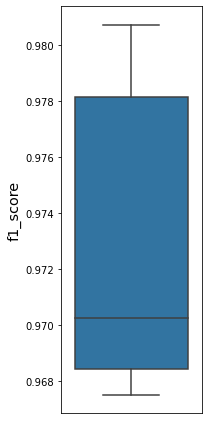

In [ ]:
fig = plt.figure(figsize=(3, 6))
sns.boxplot(y='f1_score', data=f1_df, whis=10)
#plt.ylim([0.958, 0.976])
ax = plt.gca()
l = ax.get_ylabel()
ax.set_ylabel(l, size='x-large')
ax.set_xticks([])
fig.tight_layout()

#fig.savefig('../figs/glitches/04_baseline_f1scores.png', dpi=300)

In [ ]:
f1_df.sort_values('f1_score', ascending=False)

,name,f1_score
2,run 3,0.980712
0,run 1,0.978132
4,run 5,0.970251
3,run 4,0.968429
1,run 2,0.967499


In [ ]:
f1_df.to_csv('logs/04_baseline_scratch_corrected_f1.csv')